In [176]:
import mlx.core as mx
import mlx
mx.set_default_device(mlx.core.DeviceType.gpu)

In [177]:
def softmax(x):
    e_x = mx.exp(x - mx.max(x, axis=0, keepdims=True))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=0, keepdims=True)

In [178]:
class Corpus():
    """A class to handle the corpus data for RNN."""
    def __init__(self, file_name):
        self.file_name = file_name
        self.data = open(file_name, 'r').read().split()
        self.vocab = self._get_vocab()
        self.word_to_ix = {word: i for i, word in enumerate(self.vocab)}
        self.ix_to_word = {i: word for word, i in self.word_to_ix.items()}
        # self.cooccurrence_matrix = self.compute_cooccurrence_matrix()
        # print(f"cooccurrence_matrix : {self.cooccurrence_matrix}")
        
    def embedding(self, word):
        if self.cooccurrence_matrix is None:
            print("Cooccurrence matrix not computed yet. Computing now...")
            self.cooccurrence_matrix = self.compute_cooccurrence_matrix()
        word_idx = self.word_to_ix.get(word)
        # print(f"word_idx: {word_idx}")
        if word_idx is not None:
            return self.cooccurrence_matrix[word_idx].reshape(1, -1)  # Return as a row vector
        else:
            raise ValueError("Word not in vocabulary")

    def one_hot(self, word):
        index = self.vocab.index(word)
        vector = mx.zeros(len(self.vocab))
        vector[index] = 1.0
        return vector.reshape(1, -1)

    def one_hot_to_word(self, one_hot_vector):
        index = mx.argmax(one_hot_vector)
        return self.vocab[int(index)]
    
    def _get_vocab(self):
        self.vocab = list(set(self.data))
        return self.vocab

    def get_data(self):
        return self.data
    
    def get_batched_data(self, batch_size=32):
        for i in range(len(self.data) // batch_size):
            yield self.data[i * batch_size:(i + 1) * batch_size]

    def get_dim(self):
        return len(self.vocab)
    
    def sample_word(self, y_hat, temperature=1.0):
        if temperature == 0:
            return mx.argmax(y_hat).item()  # Return the index of the highest probability word
        else:
            logits = mx.log(y_hat + 1e-10) / temperature
            exp_logits = mx.exp(logits)
            probabilities = exp_logits / mx.sum(exp_logits)
            print(f"Probabilities: {probabilities}")
            print(f"Probabilities shape: {probabilities.shape}")
            index = mx.random.categorical(probabilities).item()
            return index

    def compute_cooccurrence_matrix(self, window_size=4):
        vocab_size = len(self.vocab)
        print(f"Vocabulary size: {vocab_size}")
        self.cooccurrence_matrix = mx.zeros((vocab_size, vocab_size))
        for i, word in enumerate(self.data):
            left = max(0, i - window_size)
            right = min(len(self.data), i + window_size + 1)
            word_idx = self.word_to_ix[word]
            for j in range(left, right):
                if i != j:
                    context_idx = self.word_to_ix[self.data[j]]
                    self.cooccurrence_matrix[word_idx, context_idx] += 1

        return self.cooccurrence_matrix

In [179]:
class RNNCell():
    """A simple RNN implementation from scratch """
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
        # Initialize weights
        scale = mx.sqrt(1.0 / (input_size + output_size))  # Xavier initialization
        self.Wh = mx.random.normal(shape=(hidden_size, hidden_size), scale=scale, loc=0)
        self.Wx = mx.random.normal(shape=(hidden_size, input_size), scale=scale, loc=0)
        self.Wy = mx.random.normal(shape=(output_size, hidden_size), scale=scale, loc=0)
        self.bh = mx.zeros(shape=(hidden_size, 1))
        self.by = mx.zeros((output_size, 1))

        # Initialize hidden state and output
        self.zero_state()

        # Initialize gradients
        self.zero_grad()

    def zero_grad(self):
        """ Reset gradients to zero """
        self.dWh = mx.zeros_like(self.Wh)
        self.dWx = mx.zeros_like(self.Wx)
        self.dWy = mx.zeros_like(self.Wy)
        self.dbh = mx.zeros_like(self.bh)
        self.dby = mx.zeros_like(self.by)

    def zero_state(self):
        """ Reset hidden state and output """
        self.h_t = {}
        self.y_hat = {}
        self.x_t = {}
        self.dh_next = mx.zeros((self.hidden_size, 1))

    def forward(self, x):
        """ Forward pass through the RNN for a sequence of inputs """
        # print(f"Input sequence length: {len(x)}")
        
        for t, xt in enumerate(x):
            # print(f"t = {t}, xt len = {len(xt)}")
            self.x_t[t] = xt
            if t > 0:
                self.h_t[t] = self.tanh(self.Wx @ self.x_t[t] + self.Wh @ self.h_t[t-1] + self.bh)
            else:
                # print(f"t = {t}, xt = {self.x_t[t]}")
                # print(f"t = {t}, Wx = {self.Wx}")
                self.h_t[t] = self.tanh(self.Wx @ self.x_t[t] + self.bh)

            y_hat_temp = self.Wy @ self.h_t[t] + self.by
            self.y_hat[t] = softmax(y_hat_temp)
        
        return self.y_hat  # Return the sequence of outputs
    
    def backward(self, y, top_layer=False):
        """ Backward pass through the RNN for a sequence of outputs """
        for t in reversed(range(len(self.y_hat))):
            self.dy = self.y_hat[t] - y[t] 
            
            # print(f"t = {t}, dy = {self.dy.shape}")
            self.dWy += self.dy @ self.h_t[t].T
            self.dby += self.dy
            # print(f"dy = {self.dy.shape}")
            # print(f"dh_next = {self.dh_next.shape}")
            self.dh = self.Wy.T @ self.dy + self.dh_next
            self.dh_raw = (1 - self.h_t[t] ** 2) * self.dh # Derivative of tanh activation
            self.dWx += self.dh_raw @ self.x_t[t].T
            if t > 0:
                self.dWh += self.dh_raw @ self.h_t[t-1].T
            else:
                self.dWh += self.dh_raw @ mx.zeros_like(self.h_t[t]).T
            self.dbh += self.dh_raw
            self.dh_next = self.Wh.T @ self.dh_raw

        self.clip_gradients()  # Clip gradients to prevent exploding gradients

        return self.dWx, self.dWh, self.dWy, self.dbh, self.dby
    
    def clip_gradients(self, max_norm=5):
        # Clip gradients to prevent exploding gradients
        self.dWh = mx.clip(self.dWh, -max_norm, max_norm)
        self.dWx = mx.clip(self.dWx, -max_norm, max_norm)
        self.dWy = mx.clip(self.dWy, -max_norm, max_norm)
        self.dbh = mx.clip(self.dbh, -max_norm, max_norm)
        self.dby = mx.clip(self.dby, -max_norm, max_norm)

    def step(self, learning_rate=0.01):
        """ Update weights using gradients """
        self.Wh -= learning_rate * self.dWh
        self.Wx -= learning_rate * self.dWx
        self.Wy -= learning_rate * self.dWy
        self.bh -= learning_rate * self.dbh
        self.by -= learning_rate * self.dby
        
    def sigmoid(self, x):
        return 1 / (1 + mx.exp(-x))
    
    def tanh(self, x):
        return mx.tanh(x)
    
    def relu(self, x):
        return mx.maximum(x, 0)  # ReLU activation function

    def single_loss(self, y_hat, y):
        """ Cross-entropy loss for a single output """
        return -mx.sum(y * mx.log(y_hat + 1e-12))
    
    def categorical_cross_entropy(self, y_true, y_pred):
        # Add a small epsilon to prevent log(0)
        epsilon = 1e-15
        y_pred = mx.array([mx.clip(i, epsilon, 1 - epsilon) for i in y_pred])
        return -mx.sum(mx.array(y_true) * mx.log(y_pred))/ len(y_pred)
    
    def sequence_loss(self, y_hat, y):
        """ Cross-entropy loss """
        loss_value = 0
        for y_i, y_i_hat in zip(y, y_hat):
            loss_value += mx.sum(-1 * y_i * mx.log(y_i_hat + 1e-12)) # Adding a small value to avoid log(0)
        return loss_value / len(y_hat)


In [180]:
class RNN():
    """ Simple RNN implementation from scratch """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.cells = []
        for _ in range(num_layers):
            self.cells.append(RNNCell(input_size, hidden_size, output_size))

    def forward(self, x):
        """ Forward pass through the RNN """
        assert isinstance(x, list), "Input should be a list of inputs for each time step"

        for cell in self.cells:
            cell.zero_state()
            x = cell.forward(x)
            y_hat = [x[t] for t in range(len(x))]  # Prepare for the next cell
            x = y_hat  # Use the output of the current cell as input for the next cell

        return self.cells[-1].y_hat.values()  # Return the output of the last cell
    
    def backward(self, y):
        """ Backward pass through the RNN """
        assert isinstance(y, list), "Output should be a list of outputs for each time step"
       
        self.cells[-1].zero_grad()
        dWx, dWh, dWy, dbh, dby = self.cells[-1].backward(y, top_layer=True)  # Backward pass for the last cell

        for i in reversed(range(len(self.cells) - 1)):
            self.cells[i].zero_grad()
            self.cells[i].backward(self.cells[i+1].x_t)
        
    def step(self, learning_rate=0.01):
        """ Update weights using gradients """
        for cell in self.cells:
            cell.step(learning_rate)

    def get_y_hat(self):
        """ Get output predictions """
        return [cell.y_hat for cell in self.cells]
    
    def get_h_t(self):
        """ Get hidden states """
        return [cell.h_t for cell in self.cells]
    
    def sequence_loss(self, y_hat, y):
        """ Cross-entropy loss """
        loss_value = 0
        for y_i, y_i_hat in zip(y, y_hat):
            loss_value += mx.sum(-1 * y_i * mx.log(y_i_hat + 1e-12)) # Adding a small value to avoid log(0)
        return loss_value / len(y_hat)
    
    def zero_grad(self):
        """ Reset gradients to zero """
        for cell in self.cells:
            cell.zero_grad()



In [181]:
# Load the corpus
corpus = Corpus(file_name='sign_of_four.txt')
# corpus = Corpus(file_name='test_data.txt')
# corpus = Corpus(file_name='t8.shakespeare.txt')

In [182]:
# print(f"{type(corpus.cooccurrence_matrix)}")
# import numpy as np
# np.save('cooccurrence_matrix.npy', np.array(corpus.cooccurrence_matrix))

In [ ]:
# Create an RNN instance
NUM_LAYERS = 6  # Number of layers in the RNN
rnn = RNN(input_size=corpus.get_dim(), hidden_size=512, output_size=corpus.get_dim(), num_layers=NUM_LAYERS)

In [ ]:
SEQ_LENGTH = 8  # Length of each sequence
batch_data = corpus.get_batched_data(batch_size=SEQ_LENGTH)

In [185]:
# Step forward and backward through the RNN

train_data = next(batch_data)
print(f"train_data input = {train_data[:SEQ_LENGTH-1]}")  # Exclude the last word for prediction
print(f"train_data output = {train_data[1:SEQ_LENGTH]}")  # Exclude the first word for prediction

xt = [mx.array(corpus.one_hot(x).T) for x in train_data[:SEQ_LENGTH-1]]
print(f"xt shape = {len(xt)}")
y_hat = rnn.forward(xt)

print(f"y_hat shape = {len(y_hat)}")
# print(f"y_hat = {y_hat}")
print(f"y_hat = {[corpus.one_hot_to_word(vector) for vector in y_hat]}")  # Print the predicted outputs

# Calculate the loss
y = [corpus.one_hot(word).T for word in train_data[1:SEQ_LENGTH]]
print(f"y shape = {len(y[0])}")
# loss_value = rnn.single_loss(list(y_hat.values())[-1], y[-1])
loss_value = rnn.sequence_loss(y_hat, y)
# loss_value = rnn.categorical_cross_entropy(list(y_hat.values()), y)
print(f"Loss: {loss_value}")

# Perform backward pass
rnn.zero_grad()
rnn.backward(y)

# Update weights
rnn.step(learning_rate=0.005)  

train_data input = ['\ufeffThe', 'Project', 'Gutenberg']
train_data output = ['Project', 'Gutenberg', 'eBook']
xt shape = 3
y_hat shape = 3
y_hat = ['prohibition', 'prohibition', 'prohibition']
y shape = 9202
Loss: 9.12717342376709


In [186]:
learning_rate = 0.006
rnn_loss_history = []

index = 0
BATCH_SIZE = 50
SEQ_LENGTH = 32
EPOCHS = 100
epoch = 0
while epoch < EPOCHS:
    batch_data = corpus.get_batched_data(batch_size=SEQ_LENGTH)
    loss_value = 0
    while index < epoch * BATCH_SIZE :
        try:
            train_data = next(batch_data)
            index += 1
        except StopIteration:
            break
        rnn.zero_grad()
        xt = [corpus.one_hot(x).T for x in train_data[:SEQ_LENGTH-1]]
        # print(f"xt shape = {len(xt)}")
        y_hat = rnn.forward(xt)

        y = [corpus.one_hot(x).T for x in train_data[1:SEQ_LENGTH]]
        # loss_value = rnn.single_loss(list(y_hat.values())[-1], y[-1])
        loss_value = rnn.sequence_loss(y_hat, y)
        # loss_value = rnn.categorical_cross_entropy(list(y_hat.values()), y)
        
        print(f"epoch = {epoch} index = {index}, rnn_loss = {loss_value}")
        print(f"h_t = {[mx.max(mx.array(list(cell.h_t.values()))).item() for cell in rnn.cells]}")
        rnn.backward(y)
        rnn.step(learning_rate=learning_rate)
    epoch += 1
    print(f"Epoch {epoch} completed.")
    rnn_loss_history.append(loss_value)


Epoch 1 completed.
epoch = 1 index = 1, rnn_loss = 9.126679420471191
h_t = [0.02634507603943348, 0.0002802397357299924, 0.0002992021618410945]
epoch = 1 index = 2, rnn_loss = 9.123291015625
h_t = [0.029234573245048523, 0.00028024596394971013, 0.00115062459371984]
epoch = 1 index = 3, rnn_loss = 9.120634078979492
h_t = [0.028959525749087334, 0.0002801888040266931, 0.0017939034150913358]
epoch = 1 index = 4, rnn_loss = 9.127066612243652
h_t = [0.028787987306714058, 0.0002802266972139478, 0.002310779644176364]
epoch = 1 index = 5, rnn_loss = 9.115278244018555
h_t = [0.02872304804623127, 0.0002802273374982178, 0.00251596886664629]
epoch = 1 index = 6, rnn_loss = 9.109697341918945
h_t = [0.027513453736901283, 0.0002802528324536979, 0.0028613083995878696]
epoch = 1 index = 7, rnn_loss = 9.103461265563965
h_t = [0.026001088321208954, 0.00028034052229486406, 0.003465623827651143]
epoch = 1 index = 8, rnn_loss = 9.111340522766113
h_t = [0.03139617666602135, 0.00028020693571306765, 0.00415382673

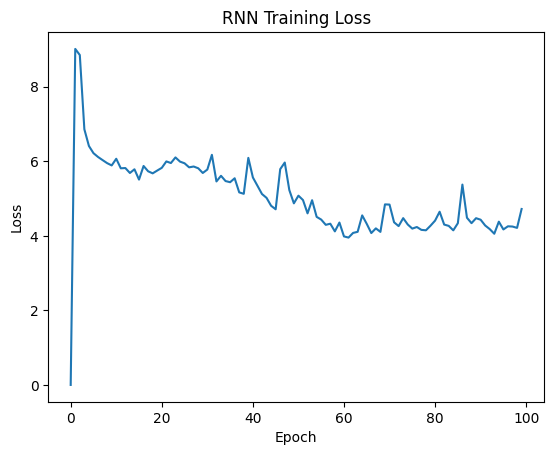

In [187]:
# Plot losses (convert to NumPy)
import numpy as np
import matplotlib.pyplot as plt
np_losses = np.array([float(l) for l in rnn_loss_history])  # MLX to NumPy
plt.plot(np_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss')
plt.show()

In [188]:
xt = [corpus.one_hot(x).T for x in train_data[:SEQ_LENGTH-1]]
y_hat = rnn.forward(xt)
y = [corpus.one_hot(x).T for x in train_data[1:SEQ_LENGTH]]

In [189]:
print(f"y_hat = {len(y_hat)}")
print(f"y = {len(y)}")

y_hat = 31
y = 31


In [190]:
rnn_loss = rnn.sequence_loss(y_hat, y)

In [191]:
print(f"rnn_loss = {rnn_loss}")

rnn_loss = 2.0126357078552246


In [192]:
# input_seq = ["Medieval", "decision.", "used"]  # Starting sequence for prediction
input_seq = ["It", "is", "of"]  # Starting sequence for prediction
print(f"Initial word: {input_seq}")

for i in range(10):
    print(f"Iteration {i+1}: seq = {input_seq}")
    # print(f"Wh = {rnn.Wh}")
    for cell in rnn.cells:
        cell.zero_state()
        
    xt = [corpus.one_hot(word).T for word in input_seq]  # Use the last two words
    # print(f"xt = {[mx.argmax(x) for x in xt]}")

    y_hat = rnn.forward(xt)
    index = corpus.sample_word(mx.array(list(y_hat)[-1]).squeeze(), temperature=0.1)  # Sample a word from the last output
    print(f"Sampled index: {index}")

    # print(f"y_hat = {mx.argmax(list(y_hat)[2])}")  # Get the predicted output for the last time step
    # print(f"y_hat = {[corpus.one_hot_to_word(vector) for vector in y_hat]}")  # Print the predicted outputs
    next_word = corpus.ix_to_word[index]  # Get the last predicted word
    input_seq.append(next_word)
    print(f"input sequence: {input_seq}")

Initial word: ['It', 'is', 'of']
Iteration 1: seq = ['It', 'is', 'of']
Probabilities: array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
Probabilities shape: (9202,)
Sampled index: 42
input sequence: ['It', 'is', 'of', 'information,”']
Iteration 2: seq = ['It', 'is', 'of', 'information,”']
Probabilities: array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
Probabilities shape: (9202,)
Sampled index: 766
input sequence: ['It', 'is', 'of', 'information,”', 'continually']
Iteration 3: seq = ['It', 'is', 'of', 'information,”', 'continually']
Probabilities: array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
Probabilities shape: (9202,)
Sampled index: 4923
input sequence: ['It', 'is', 'of', 'information,”', 'continually', 'burglary.']
Iteration 4: seq = ['It', 'is', 'of', 'information,”', 'continually', 'burglary.']
Probabilities: array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
Probabilities shape: (9202,)
Sampled index: 861
input sequence: ['It', 'is', 'of', 'information,”', 'continually', 'burglary.', 'explo

In [150]:
print(f"vocab size = {len(corpus._get_vocab())}")
print(f"word = {corpus.ix_to_word[6607]}")

for cell in rnn.cells:
    print(f"h_t = {cell.h_t}")

vocab size = 9202
word = to
h_t = {0: array([[0.00585308],
       [0.0101117],
       [-0.00650536],
       ...,
       [0.00305969],
       [-0.00194587],
       [-0.00401395]], dtype=float32), 1: array([[-0.000609711],
       [-0.0108794],
       [-0.0147119],
       ...,
       [-0.0145678],
       [0.0071245],
       [0.00768881]], dtype=float32), 2: array([[0.000785334],
       [0.00291874],
       [-0.00026465],
       ...,
       [-0.0101385],
       [0.000935584],
       [0.00190081]], dtype=float32)}
h_t = {0: array([[-0.00011898],
       [-8.29557e-05],
       [-1.02277e-05],
       ...,
       [-5.97885e-05],
       [-2.56229e-05],
       [-2.92392e-05]], dtype=float32), 1: array([[-0.000129681],
       [-0.000100223],
       [9.22267e-06],
       ...,
       [-2.40759e-05],
       [-2.49085e-05],
       [-2.31509e-05]], dtype=float32), 2: array([[-0.000129642],
       [-9.78698e-05],
       [9.40947e-06],
       ...,
       [-2.48017e-05],
       [-2.44486e-05],
       [-2.